In [ ]:
#Compared to v2:

# Fixed the demo consolitade tables for p2p, as it did not include the weighting
# Made it a bit clearer how i was going to proceed (distinguishing the simple subewight/weight compared to the groupby process)
# for that i needed to move some stuff around but its (nearly) the same code. Also added my version of the P2P column and used that instead
# of the inherited column from the Excel file
# Added p2p stuggling + average savings + average credit score
# Addded "sample" to multi index tables
# swapped al hard code instances of April 2023 for current_month text object

## Next up: started doing share using select credit products and already added the demo split by financial status,
## need to create the rest of splits then consolidate all in one large table
## my intention is continuing to append results into cproducts_tc; loop established for p2p split should work for the rest

# Q&A calculator

## Setting up the Lending Club time comparisons

First: share living paycheck to paycheck by time

**Importing libraries, loading csv**

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
dir_path = 'C:/Users/marco/Dropbox (MPD)/Analytics Argentina/Billable products/Surveys/Lending Club/All RDs'

# Change the working directory to the specified path
os.chdir(dir_path)

In [3]:
# Needs to be updated periodically

current_month = "April 2023"
current_order = ['November 2021','December 2021','January 2022','February 2022', 'March 2022','April 2022',
                 'May 2022', "June 2022", "July 2022", "August 2022", "September 2022", "October 2022",
                 "November 2022", "December 2022", "January 2023",'February 2023',"March 2023","April 2023"]

In [4]:
#Setting up dataframe + codebook

df=pd.read_csv('LC18.csv', low_memory=False) #harcoded reference

#double header, will create a codebook but for now im just keeping the code and not the description
df=df.drop(0)
# it imported some whitenoise, as all responses must have a startdate
df=df[df["StartDate"].notnull()]
 # No test responses considered
df=df[df["Status"]=="IP Address"]

print(f"Load successful. {df.shape[0]} rows and {df.shape[1]} columns loaded into dataframe")

codebook=pd.read_csv('LC18.csv', low_memory=False)
codebook=codebook.loc[0].to_dict()

Load successful. 3652 rows and 277 columns loaded into dataframe


### Pre processing

In [5]:
# Need to format dates because they got imported as numbers

date_columns=['StartDate','EndDate']
for col in date_columns:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(int)
    df[col]= df[col]+ 693594 # Offset for converting to a valid date in the Gregorian calendar
    df[col] = df[col].apply(lambda x: datetime.fromordinal(x))
    df[col] = df[col].apply(lambda x: x.strftime('%Y-%m-%d'))
    
print('Check dates: look ok?')
print(np.sort(df.EndDate.unique()))

Check dates: look ok?
['2023-04-03' '2023-04-04' '2023-04-05' '2023-04-06' '2023-04-07'
 '2023-04-08' '2023-04-09' '2023-04-10' '2023-04-11' '2023-04-12'
 '2023-04-13' '2023-04-14' '2023-04-15' '2023-04-16' '2023-04-17']


In [6]:
# Need to format weight as a float

df.weight=df.weight.astype(float)
print("Weight sum should be 260M or similar")
print(df.weight.sum())

Weight sum should be 260M or similar
260086951.46169


### Share of consumers living paycheck to paycheck

In [7]:
# defining a function that helps me find codes for questions
#searching the codebook, as raw data has been stripped of the description

def q_finder(word_to_find):
    for key, value in codebook.items():
        if word_to_find in value.lower():
            print(f"Word '{word_to_find}' found in key: {key}")

In [8]:
# Analysis needs financial lifestyle column as an input

q_finder('financial lifestyle')
df.D15.unique()

Word 'financial lifestyle' found in key: D15


array(['I live paycheck to paycheck and have issues paying my bills each month.',
       'I live paycheck to paycheck but am comfortably paying my bills each month.',
       'I do not live paycheck to paycheck and have more than enough earnings to cover my bills each month.'],
      dtype=object)

In [9]:
#Full description is too long
#Three mappings: Changing from first person to neutral wording, another for shorthand acess and a two group-only version
#im appling the first directly into D15; this is means overwrite the raw data but i really see no use in the original wording

p2p_cleaner = {'I live paycheck to paycheck and have issues paying my bills each month.': 'Paycheck to paycheck and struggling',
           'I live paycheck to paycheck but am comfortably paying my bills each month.': 'Paycheck to paycheck but not struggling',
           'I do not live paycheck to paycheck and have more than enough earnings to cover my bills each month.': 'Not paycheck to paycheck'}

df.D15=df.D15.map(p2p_cleaner)

#

p2p_short = {'Paycheck to paycheck and struggling':'Struggle',
           'Paycheck to paycheck but not struggling': 'P2P',
           'Not paycheck to paycheck':'NotP2P'}

df['D15_short']=df.D15.map(p2p_short)

#

p2p_TwoGroups = {'Paycheck to paycheck and struggling':'P2P',
           'Paycheck to paycheck but not struggling': 'P2P',
           'Not paycheck to paycheck':'NotP2P'}

df['D15_TwoGroups']=df.D15.map(p2p_TwoGroups)

# establishing the predifined order for later on:
p2p_order = ['Paycheck to paycheck and struggling','Paycheck to paycheck but not struggling','Not paycheck to paycheck']

In [10]:
# checking

print(df.D15.unique())
print("*"*10)
print(df.D15_short.unique())
print("*"*10)
print(df.D15_TwoGroups.unique()) # it's central to the analysis that there are no values outside the three expected values
print("*"*10)
print(f'{df.D15.isnull().sum()} null values in target column')

['Paycheck to paycheck and struggling'
 'Paycheck to paycheck but not struggling' 'Not paycheck to paycheck']
**********
['Struggle' 'P2P' 'NotP2P']
**********
['P2P' 'NotP2P']
**********
0 null values in target column


### Share of consumers living paycheck to paycheck

In [11]:
# the process is simple. you define a group (First it will be the whole sample) and split by financial lifestyle
# add up all the weights in the p2p subgroup then divide by the summed weights in the whole set
# then storing results in dataframe, this will simplify compilying over time and demo afterwards

wSample=df.weight.sum()
ppwSample=df[df['D15_TwoGroups']=='P2P']['weight'].sum()
sample_share=ppwSample/wSample

# this might look weird at this point, but i already know the shape of the dataframe i'll want down the road so im doing some
# tweaks to the dataframe: adding another column that specifies among what consumers im calculating (in this case sample)
# also renaming the axes to "Group", given that i may have the same calculation for different groups in a same table

sample_share=pd.DataFrame(sample_share, index=['Sample'], columns=[current_month])
sample_share=sample_share.rename_axis('Group')
sample_share.insert(0,"Two-level",'Sample') #hard coded
sample_share

,Two-level,April 2023
Group,,
Sample,Sample,0.611014


In [12]:
# Getting the shares for each group instead of one metric is (slightly) different
# using groupby to sum weights per group, then again divide by the total weight

# Splitting sample by p2p status + summing weights
p2p_groups=df.groupby('D15') #hard coded
p2p_weight_subtotals = p2p_groups['weight'].sum()

#total weights (denominator)
total_weight = p2p_weight_subtotals.sum()
weight_shares = p2p_weight_subtotals / total_weight

sample_p2p_shares = pd.DataFrame({current_month: weight_shares}) #Date is hard coded

# same edits to the dataframe

sample_p2p_shares=sample_p2p_shares.reindex(p2p_order)
sample_p2p_shares=sample_p2p_shares.rename_axis('Group')
sample_p2p_shares.insert(0,"Two-level",'Sample')
sample_p2p_shares

,Two-level,April 2023
Group,,
Paycheck to paycheck and struggling,Sample,0.192258
Paycheck to paycheck but not struggling,Sample,0.418757
Not paycheck to paycheck,Sample,0.388986


In [13]:
sample_p2p_shares['April 2023'].sum()

1.0

#### Share of consumers living paycheck to paycheck: Demo comparisons

In [146]:
# process is the same, only difference is that i need to get all the denominators first which is the population of each demo group
# defining my target demographic subsets and the respective populations by split
# Age, income (3 and 5 splits), and gender. P2P not included because its the baseline split

wP2P = df.groupby('D15')['weight'].sum()
wP2P_TwoGroups = df.groupby('D15_TwoGroups')['weight'].sum()
wGens = df.groupby('Generation')['weight'].sum()
wIncome5 = df.groupby('Q_income_RB')['weight'].sum()
wIncome3 = df.groupby('income_3G')['weight'].sum()
wGender = df.groupby('L_gender')['weight'].sum()

In [15]:
# Two silly checks  
print("Number of consumers by generation (should add up to 260 or similar):")
print(wGens/1000000)
print("*"*10)
print("Share of consumers by income:")
print(wIncome5/260000000) #go back and ensure these shares match the current lending analysis)

Number of consumers by generation (should add up to 260 or similar):
Generation
Baby boomers and seniors    90.439987
Generation X                63.392723
Generation Z                31.732627
Millennials                 74.521614
Name: weight, dtype: float64
**********
Share of consumers by income:
Q_income_RB
$100K-$150K    0.179064
$150K-$200K    0.088617
$200K-$250K    0.040706
$250K+         0.062430
$50K-$100K     0.301647
Under $50K     0.327870
Name: weight, dtype: float64


In [16]:
# paycheck to paycheck populations withing each subgroup of each split

ppwGens=df[df['D15_TwoGroups']=='P2P'].groupby('Generation')['weight'].sum()
ppwInc5=df[df['D15_TwoGroups']=='P2P'].groupby('Q_income_RB')['weight'].sum()
ppwInc3=df[df['D15_TwoGroups']=='P2P'].groupby('income_3G')['weight'].sum()
ppwGender=df[df['D15_TwoGroups']=='P2P'].groupby('L_gender')['weight'].sum()

In [17]:
# eyeball shares of p2p by generation, make sense?
ppwGens/wGens

Generation
Baby boomers and seniors    0.502782
Generation X                0.631301
Generation Z                0.579320
Millennials                 0.738606
Name: weight, dtype: float64

#### Consolidating a demo p2p time comparison single table

In [18]:
# Generations
gen_shares=ppwGens/wGens
gen_shares=pd.DataFrame(index=gen_shares.index, data=gen_shares.values, columns=['April 2023'])
gen_order = ['Generation Z', 'Millennials', 'Generation X','Baby boomers and seniors']
gen_shares=gen_shares.reindex(gen_order)
gen_shares=gen_shares.rename_axis('Group')
gen_shares.insert(0,"Two-level",'Generation') #hard coded
gen_shares

,Two-level,April 2023
Group,,
Generation Z,Generation,0.579320
Millennials,Generation,0.738606
Generation X,Generation,0.631301
Baby boomers and seniors,Generation,0.502782


In [19]:
#B) Income: 5 groups

income5_shares=ppwInc5/wIncome5
income5_shares=pd.DataFrame(index=income5_shares.index, data=income5_shares.values, columns=['April 2023'])
inc5_order = ['Under $50K', '$50K-$100K', '$100K-$150K','$150K-$200K','$200K-$250K','$250K+']
income5_shares=income5_shares.reindex(inc5_order)
income5_shares=income5_shares.rename_axis('Group')
income5_shares.insert(0,"Two-level",'Income 5') #hard coded
income5_shares

,Two-level,April 2023
Group,,
Under $50K,Income 5,0.734465
$50K-$100K,Income 5,0.628859
$100K-$150K,Income 5,0.565786
$150K-$200K,Income 5,0.530463
$200K-$250K,Income 5,0.450734
$250K+,Income 5,0.225025


In [20]:
#C) Income: 3 groups

income3_shares=ppwInc3/wIncome3
income3_shares=pd.DataFrame(index=income3_shares.index, data=income3_shares.values, columns=['April 2023'])
inc3_order = ['Under $50K', '$50K-$100K', '$100K+']
income3_shares=income3_shares.reindex(inc3_order)
income3_shares=income3_shares.rename_axis('Group')
income3_shares.insert(0,"Two-level",'Income 3') #hard coded
income3_shares

,Two-level,April 2023
Group,,
Under $50K,Income 3,0.734465
$50K-$100K,Income 3,0.628859
$100K+,Income 3,0.487345


In [21]:
# Gender

gender_shares=ppwGender/wGender
gender_shares=pd.DataFrame(index=gender_shares.index, data=gender_shares.values, columns=['April 2023'])
gender_order = ['Female', 'Male']
gender_shares=gender_shares.reindex(gender_order)
gender_shares=gender_shares.rename_axis('Group')
gender_shares.insert(0,"Two-level",'Gender') #hard coded
gender_shares

,Two-level,April 2023
Group,,
Female,Gender,0.602851
Male,Gender,0.619638


In [22]:
## Putting it all toghether
p2p_all_demos=pd.concat([sample_share,gen_shares,income3_shares,income5_shares,gender_shares],axis=0)
p2p_all_demos

,Two-level,April 2023
Group,,
Sample,Sample,0.611014
Generation Z,Generation,0.579320
Millennials,Generation,0.738606
Generation X,Generation,0.631301
Baby boomers and seniors,Generation,0.502782
Under $50K,Income 3,0.734465
$50K-$100K,Income 3,0.628859
$100K+,Income 3,0.487345
Under $50K,Income 5,0.734465


### Share of consumers struggling to pay bills

In [23]:
# financially struggling populations withing each subgroup of each split

ppswSample=df[df['D15']=='Paycheck to paycheck and struggling']['weight'].sum()
ppswGens=df[df['D15']=='Paycheck to paycheck and struggling'].groupby('Generation')['weight'].sum() 
ppswInc5=df[df['D15']=='Paycheck to paycheck and struggling'].groupby('Q_income_RB')['weight'].sum()
ppswInc3=df[df['D15']=='Paycheck to paycheck and struggling'].groupby('income_3G')['weight'].sum()
ppswGender=df[df['D15']=='Paycheck to paycheck and struggling'].groupby('L_gender')['weight'].sum()

In [24]:
# eyeballing one example - income 3g
ppswInc3/wIncome3

income_3G
$100K+        0.121330
$50K-$100K    0.170963
Under $50K    0.292067
Name: weight, dtype: float64

#### Consolidating

In [25]:
# Sample

struggling_share=ppswSample/wSample

struggling_share=pd.DataFrame(struggling_share, index=['Sample'], columns=[current_month])
struggling_share=struggling_share.rename_axis('Group')
struggling_share.insert(0,"Two-level",'Sample') #hard coded
struggling_share

#A) Generations
gen_shares_struggling=ppswGens/wGens
gen_shares_struggling=pd.DataFrame(index=gen_shares_struggling.index, data=gen_shares_struggling.values, columns=['April 2023'])
gen_shares_struggling=gen_shares_struggling.reindex(gen_order) #order was already defined in p2p section
gen_shares_struggling=gen_shares_struggling.rename_axis('Group')
gen_shares_struggling.insert(0,"Two-level",'Generation') #hard coded

#B) Income: 5 groups

income5_shares_struggling=ppswInc5/wIncome5
income5_shares_struggling=pd.DataFrame(
    index=income5_shares_struggling.index, data=income5_shares_struggling.values, columns=['April 2023'])
income5_shares_struggling=income5_shares_struggling.reindex(inc5_order)
income5_shares_struggling=income5_shares_struggling.rename_axis('Group')
income5_shares_struggling.insert(0,"Two-level",'Income 5') #hard coded

#C) Income: 3 groups

income3_shares_struggling=ppswInc3/wIncome3
income3_shares_struggling=pd.DataFrame(
    index=income3_shares_struggling.index, data=income3_shares_struggling.values, columns=['April 2023'])
income3_shares=income3_shares_struggling.reindex(inc3_order)
income3_shares=income3_shares_struggling.rename_axis('Group')
income3_shares_struggling.insert(0,"Two-level",'Income 3') #hard coded


#D) Gender

gender_shares_struggling=ppswGender/wGender
gender_shares_struggling=pd.DataFrame(
    index=gender_shares_struggling.index, data=gender_shares_struggling.values, columns=['April 2023'])
gender_shares_struggling=gender_shares_struggling.reindex(gender_order)
gender_shares_struggling=gender_shares_struggling.rename_axis('Group')
gender_shares_struggling.insert(0,"Two-level",'Gender') #hard coded

## Putting it all toghether
p2p_struggling_all_demos=pd.concat(
    [struggling_share,gen_shares_struggling,income3_shares_struggling,income5_shares_struggling,gender_shares_struggling],axis=0)
p2p_struggling_all_demos

,Two-level,April 2023
Sample,Sample,0.192258
Generation Z,Generation,0.155182
Millennials,Generation,0.287647
Generation X,Generation,0.179484
Baby boomers and seniors,Generation,0.135621
$100K+,Income 3,0.121330
$50K-$100K,Income 3,0.170963
Under $50K,Income 3,0.292067
Under $50K,Income 5,0.292067
$50K-$100K,Income 5,0.170963


### Sumproduct template: average savings, average credit score

#### Average savings

In [26]:
# Defining a function to shorten typing in the future when averaging numerical values using the weights

# this one only works in the full sample
def weighted_average(values):
    if len(values) != len(df.weight):
        raise ValueError("Number of values and weights must be the same.")
    
    total_weight = sum(df.weight)
    weighted_sum = sum(value * weight for value, weight in zip(values, df.weight))
    
    return weighted_sum / total_weight

def weighted_average_group(values, weights):
    if len(values) != len(weights):
        raise ValueError("Number of values and weights must be the same.")
    
    total_weight = sum(weights)
    weighted_sum = sum(value * weight for value, weight in zip(values, weights))
    
    return weighted_sum / total_weight

In [27]:
q_finder("savings") # its D16

Word 'savings' found in key: D15a_8
Word 'savings' found in key: D16
Word 'savings' found in key: D17_5
Word 'savings' found in key: Savings_V2


In [28]:
df.D16.unique()

array(['I have no savings.', 'Between $500 and $1,000',
       'Between $1,001 and $2,500', 'More than $25,000',
       'Between $5,001 and $10,000', 'Between $10,001 and $15,000',
       'Between $2,501 and $5,000', 'Between $15,001 and $25,000',
       'Less than $500'], dtype=object)

<AxesSubplot:>

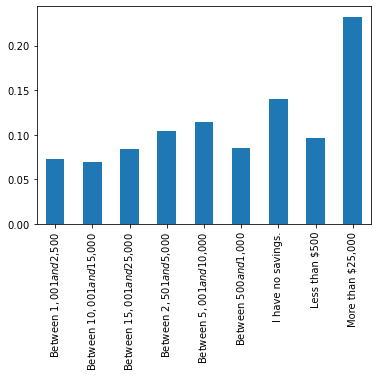

In [39]:
df['D16'].value_counts(normalize=True).sort_index().plot(kind="bar")

In [29]:
savings_to_numerical={
    'I have no savings.':0,
    'Less than $500':250,
    'Between $500 and $1,000':750,
    'Between $1,001 and $2,500':1750,
    'Between $2,501 and $5,000':3750, 
    'Between $5,001 and $10,000':7500,
    'Between $10,001 and $15,000':12500,
    'Between $15,001 and $25,000':20000,
    'More than $25,000':32500    
}

df['D16_numerical']=df.D16.map(savings_to_numerical)

<AxesSubplot:>

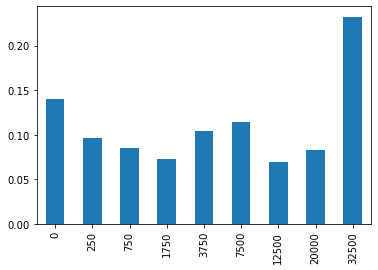

In [38]:
df['D16_numerical'].value_counts(normalize=True).sort_index().plot(kind="bar")

In [40]:
savings={current_month:weighted_average(df['D16_numerical'])}

sample_savings = pd.DataFrame(
    data=savings.values(),
    index= ["Sample"],
    columns= savings.keys(),
)
sample_savings.index.name = 'Group'
sample_savings.insert(0,"Two-level",'Sample') #hard coded

In [41]:
sample_savings

,Two-level,April 2023
Group,,
Sample,Sample,12826.941424


In [42]:
# by financial lifestyle
p2p_savings=df.groupby('D15').apply(lambda x: weighted_average_group(x['D16_numerical'], x['weight']))
p2p_savings=pd.DataFrame(index=p2p_savings.index, data=p2p_savings.values, columns=[current_month])
p2p_savings=p2p_savings.reindex(p2p_order) #order was already defined in p2p section
p2p_savings=p2p_savings.rename_axis('Group')
p2p_savings.insert(0,"Two-level",'Financial lifestyle') #hard coded

#generation
gen_savings=df.groupby('Generation').apply(lambda x: weighted_average_group(x['D16_numerical'], x['weight']))
gen_savings=pd.DataFrame(index=gen_savings.index, data=gen_savings.values, columns=[current_month])
gen_savings=gen_savings.reindex(gen_order) #order was already defined in p2p section
gen_savings=gen_savings.rename_axis('Group')
gen_savings.insert(0,"Two-level",'Generation') #hard coded

#Income: 3 groups

inc3_savings=df.groupby('income_3G').apply(lambda x: weighted_average_group(x['D16_numerical'], x['weight']))
inc3_savings=pd.DataFrame(index=inc3_savings.index, data=inc3_savings.values, columns=[current_month])
inc3_savings=inc3_savings.reindex(inc3_order) #order was already defined in p2p section
inc3_savings=inc3_savings.rename_axis('Group')
inc3_savings.insert(0,"Two-level",'Income 3') #hard coded

#Income: 5 groups

inc5_savings=df.groupby('Q_income_RB').apply(lambda x: weighted_average_group(x['D16_numerical'], x['weight']))
inc5_savings=pd.DataFrame(index=inc5_savings.index, data=inc5_savings.values, columns=[current_month])
inc5_savings=inc5_savings.reindex(inc5_order) #order was already defined in p2p section
inc5_savings=inc5_savings.rename_axis('Group')
inc5_savings.insert(0,"Two-level",'Income 5') #hard coded

#Gender

gender_savings=df.groupby('L_gender').apply(lambda x: weighted_average_group(x['D16_numerical'], x['weight']))
gender_savings=pd.DataFrame(index=gender_savings.index, data=gender_savings.values, columns=[current_month])
gender_savings=gender_savings.reindex(gender_order) #order was already defined in p2p section
gender_savings=gender_savings.rename_axis('Group')
gender_savings.insert(0,"Two-level",'Gender') #hard coded

## Putting it all toghether
savings_tc=pd.concat(
    [sample_savings,p2p_savings,gen_savings,inc3_savings,inc5_savings,gender_savings],axis=0)

savings_tc

,Two-level,April 2023
Group,,
Sample,Sample,12826.941424
Paycheck to paycheck and struggling,Financial lifestyle,5236.590618
Paycheck to paycheck but not struggling,Financial lifestyle,8781.495677
Not paycheck to paycheck,Financial lifestyle,20933.567656
Generation Z,Generation,10198.055889
Millennials,Generation,10702.546847
Generation X,Generation,12419.959665
Baby boomers and seniors,Generation,15785.084696
Under $50K,Income 3,7833.139380


#### Average credit score

In [44]:
q_finder("credit score")

Word 'credit score' found in key: D28
Word 'credit score' found in key: D28a
Word 'credit score' found in key: Credit score


In [46]:
# I will need to drop nulls for the average so cant work with original dataframe

df_cscores=df.copy()
df_cscores=df_cscores[['D28','D15','D15_TwoGroups','Generation','Q_income_RB','income_3G','L_gender','weight']]
df_cscores=df_cscores[df_cscores.D28 != "I don't know / I am not sure"]
df_cscores=df_cscores[df_cscores.D28 != "I don't have a credit score"]
df_cscores.D28.unique()

array(['601 to 650', '300 to 400', '651 to 700', '701 to 750',
       '801 to 850', '501 to 600', '751 to 800', '401 to 500'],
      dtype=object)

In [47]:
scores_to_numerical={
    "300 to 400":350,
    "401 to 500":450,
    "501 to 600":550,
    "601 to 650":625,
    "651 to 700":675,
    "701 to 750":725,
    "751 to 800":775.5,
    "801 to 850":825,  
}

df_cscores['D28_numerical']=df_cscores.D28.map(scores_to_numerical)

In [48]:
df_cscores.D28_numerical.unique()

array([625. , 350. , 675. , 725. , 825. , 550. , 775.5, 450. ])

In [57]:
weighted_scores=df_cscores.D28_numerical*df_cscores.weight
average_credit_score=weighted_scores.sum()/df_cscores.weight.sum()

In [58]:
sample_cscores = pd.DataFrame(
    data=average_credit_score,
    index= ["Sample"],
    columns= [current_month],
)
sample_cscores.index.name = 'Group'
sample_cscores.insert(0,"Two-level",'Sample') #hard coded
sample_cscores

,Two-level,April 2023
Group,,
Sample,Sample,712.474782


In [ ]:
# by financial lifestyle
p2p_cscores=df_cscores.groupby('D15').apply(lambda x: weighted_average_group(x['D28_numerical'], x['weight']))
p2p_cscores=pd.DataFrame(index=p2p_cscores.index, data=p2p_cscores.values, columns=[current_month])
p2p_cscores=p2p_cscores.reindex(p2p_order) #order was already defined in p2p section
p2p_cscores=p2p_cscores.rename_axis('Group')
p2p_cscores.insert(0,"Two-level",'Financial lifestyle') #hard coded

#generation
gen_cscores=df_cscores.groupby('Generation').apply(lambda x: weighted_average_group(x['D28_numerical'], x['weight']))
gen_cscores=pd.DataFrame(index=gen_cscores.index, data=gen_cscores.values, columns=[current_month])
gen_cscores=gen_cscores.reindex(gen_order) #order was already defined in p2p section
gen_cscores=gen_cscores.rename_axis('Group')
gen_cscores.insert(0,"Two-level",'Generation') #hard coded

#Income: 3 groups

inc3_cscores=df_cscores.groupby('income_3G').apply(lambda x: weighted_average_group(x['D28_numerical'], x['weight']))
inc3_cscores=pd.DataFrame(index=inc3_cscores.index, data=inc3_cscores.values, columns=[current_month])
inc3_cscores=inc3_cscores.reindex(inc3_order) #order was already defined in p2p section
inc3_cscores=inc3_cscores.rename_axis('Group')
inc3_cscores.insert(0,"Two-level",'Income 3') #hard coded

#Income: 5 groups

inc5_cscores=df_cscores.groupby('Q_income_RB').apply(lambda x: weighted_average_group(x['D28_numerical'], x['weight']))
inc5_cscores=pd.DataFrame(index=inc5_cscores.index, data=inc5_cscores.values, columns=[current_month])
inc5_cscores=inc5_cscores.reindex(inc5_order) #order was already defined in p2p section
inc5_cscores=inc5_cscores.rename_axis('Group')
inc5_cscores.insert(0,"Two-level",'Income 5') #hard coded

#Gender

gender_cscores=df_cscores.groupby('L_gender').apply(lambda x: weighted_average_group(x['D28_numerical'], x['weight']))
gender_cscores=pd.DataFrame(index=gender_cscores.index, data=gender_cscores.values, columns=[current_month])
gender_cscores=gender_cscores.reindex(gender_order) #order was already defined in p2p section
gender_cscores=gender_cscores.rename_axis('Group')
gender_cscores.insert(0,"Two-level",'Gender') #hard coded

In [69]:
## Putting it all toghether
cscores_tc=pd.concat(
    [sample_cscores,p2p_cscores,gen_cscores,inc3_cscores,inc5_cscores,gender_cscores],axis=0)

cscores_tc

,Two-level,April 2023
Group,,
Sample,Sample,712.474782
Paycheck to paycheck and struggling,Financial lifestyle,640.815471
Paycheck to paycheck but not struggling,Financial lifestyle,691.261162
Not paycheck to paycheck,Financial lifestyle,769.519661
Generation Z,Generation,682.487338
Millennials,Generation,678.316796
Generation X,Generation,703.288278
Baby boomers and seniors,Generation,756.866678
Under $50K,Income 3,675.837580


### Share making payments related to credit products

In [70]:
q_finder("credit product") # its D16

Word 'credit product' found in key: D26_1
Word 'credit product' found in key: D26_4
Word 'credit product' found in key: D26_5
Word 'credit product' found in key: D26_6
Word 'credit product' found in key: D26_7
Word 'credit product' found in key: D26_8
Word 'credit product' found in key: D26_9
Word 'credit product' found in key: D26_10
Word 'credit product' found in key: D26_11
Word 'credit product' found in key: D26_13
Word 'credit product' found in key: D26_14
Word 'credit product' found in key: D26_12


In [86]:
# this is a bit tricky because data is scattered in multiple columns
# i start off by fetching all unique values other than 0 in each column
# then its just about looping throughout and summing the weights of the rows when code=value

cproduct_cols=[]

for key in codebook:
    if 'D26' in key:
        cproduct_cols.append(key)

In [87]:
cproduct_cols #some non raw data columns here, dropping

['D26_1',
 'D26_4',
 'D26_5',
 'D26_6',
 'D26_7',
 'D26_8',
 'D26_9',
 'D26_10',
 'D26_11',
 'D26_13',
 'D26_14',
 'D26_12',
 'D26.v2']

In [91]:
cproduct_cols.remove('D26.v2')

In [105]:
# creating a list with all credit products listed in each column (one each, excluding zeros which mean don't have)
cproducts=[]

for col in cproduct_cols:
    cproducts.extend(df[col].unique()[df[col].unique()!='0'].tolist())

cproducts

In [137]:
#now looping through and summing the weights for all affirmative responses per product


cproduct_shares={}
for col, product in zip(cproduct_cols,cproducts):
    share_using_cp=df[df[col]==product].weight.sum()/wSample
    cproduct_shares[product]=share_using_cp
    
cproduct_shares=pd.DataFrame(data=cproduct_shares.values(), index=cproduct_shares.keys(), columns=[current_month])

In [141]:
# Im going to use the current ranking to create the pre-established order
# i cannot let this float because i run a risk of appending stuff in mixed places if the order changes
# cproduct_shares.sort_values(by=current_month,ascending=False).index.tolist()

# 'None' goes last

cproduct_order=['Credit card',
 'Auto loan',
 'Mortgage loan, refinancing',
 'Personal loan',
 'Buy Now, Pay Later (installment credit)',
 'Mortgage loan, first-time buying',
 'Student loan',
 'Home equity loan',
 'Debt consolidation loan',
 'Business lines of credit',
 'Second mortgage',
  'None of these']

cproduct_shares.reindex(cproduct_order)
cproduct_shares=cproduct_shares.rename_axis('Group')
cproduct_shares.insert(0,"Two-level",'Sample') #hard coded

In [142]:
cproduct_shares

,Two-level,April 2023
Group,,
Credit card,Sample,0.665772
"Mortgage loan, first-time buying",Sample,0.116373
"Mortgage loan, refinancing",Sample,0.170599
Second mortgage,Sample,0.033497
Personal loan,Sample,0.158918
Home equity loan,Sample,0.074918
Auto loan,Sample,0.297956
"Buy Now, Pay Later (installment credit)",Sample,0.128421
Business lines of credit,Sample,0.058881


In [184]:
cproducts_tc = pd.DataFrame(columns=['Two-level','Product',current_month])

# by financial lifestyle

for col, product in zip(cproduct_cols,cproducts):
    cpw_p2p=df[df[col]==product].groupby('D15')['weight'].sum()
    product_table=pd.DataFrame(data=cpw_p2p/wP2P) 
    product_table=product_table.reindex(p2p_order)
    product_table = product_table.rename(columns={'weight': current_month})
    product_table.insert(0,"Two-level",'Financial lifestyle') #hard coded
    product_table.insert(1,"Product",product) #hard coded
    cproducts_tc= pd.concat([cproducts_tc, product_table])
    cproducts_tc= cproducts_tc.rename_axis('Group')